In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/btcinusd/BTC-2019min.csv
/kaggle/input/btcinusd/BTC-Hourly.csv
/kaggle/input/btcinusd/BTC-Daily.csv
/kaggle/input/btcinusd/BTC-2020min.csv
/kaggle/input/btcinusd/BTC-2017min.csv
/kaggle/input/btcinusd/BTC-2018min.csv
/kaggle/input/btcinusd/BTC-2021min.csv


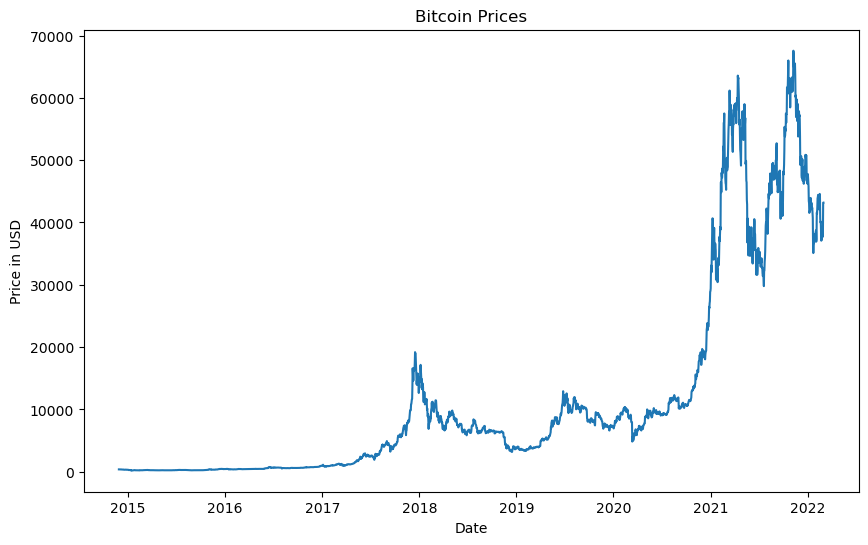

NameError: name 'look_back' is not defined

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


# Load the data, set index to date, reverse the index to get correct order
df = pd.read_csv('/kaggle/input/btcinusd/BTC-Daily.csv', parse_dates=['date'])
df = df[['date', 'close']]
df.index = pd.to_datetime(df.index)
df = df.set_index('date')
df = df.iloc[::-1]


# Plot the raw bitcoin price data
plt.figure(figsize=(10,6))
plt.title('Bitcoin Prices')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.plot(df)
plt.show()


# Split the data into training and testing sets
data = df.values
# Train on the first 83%
train_data = data[:math.ceil(len(data)*0.83)]
# Test on the last 17%
test_data = data[math.ceil(len(data)*0.83):]


# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)


# Create the training and testing datasets
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        Y.append(data[(i+look_back), 0])
    return np.array(X), np.array(Y)

#Scale the dataset
X_train, Y_train = create_dataset(train_data_scaled, look_back)
X_test, Y_test = create_dataset(test_data_scaled, look_back)

# Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, epochs=5, batch_size=32)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# Plot the results
plt.figure(figsize=(10,6))
plt.title('Training Data and Predicted vs Actual Bitcoin Prices')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.plot(df.index[look_back:len(train_data_scaled)-1],Y_train.reshape(-1,1),color='red', label='Training Data')
plt.plot(df.index[len(train_data_scaled)+(look_back):len(data)-1],test_predict,color='green', label='Predicted Data')
plt.plot(df, color='blue',label='Bitcoin Price Data')
plt.legend()
plt.show()